In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/broutanlab_course/

Mounted at /content/drive
/content/drive/My Drive/broutanlab_course


![](https://bloglunit.files.wordpress.com/2017/06/e18480e185b3e18485e185b5e186b71.png?w=740)

Рассмотрим модель NIC, которая состоит из двух моделей CNN + RNN. CNN используется для извлечения фич из изображения, а RNN для генерации описания.

Для обучения модели будем использовать датасет [MSCOCO](https://cocodataset.org/#download).

Ноутбук основан на базе учебного проекта для [Deep Learning School (dlschool.org)](https://www.dlschool.org/).

In [ ]:
!nvidia-smi

Mon Apr 12 06:32:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 40kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=f7ab0d9da911ae986a27f49158fe5459365184bfe9d7bdfe6c3781725caaad58
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import face_recognition
from sklearn import svm
import os
from imutils import paths
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# Training the SVC classifier

# The training data would be all the face encodings from all the known images and the labels are their names
encodings = []
names = []

# Training directory
train_dir = os.listdir('dataset4/')


# Loop through each person in the training directory
for person in train_dir:
    pix = os.listdir("dataset4/" + person)

    # Loop through each training image for the current person
    for person_img in pix:
        # Get the face encodings for the face in each image file
        face = face_recognition.load_image_file("dataset4/" + person + "/" + person_img)
        face_bounding_boxes = face_recognition.face_locations(face)

        #If training image contains exactly one face
        if len(face_bounding_boxes) == 1:
            face_enc = face_recognition.face_encodings(face)[0]
            # Add face encoding for current image with corresponding label (name) to the training data
            encodings.append(face_enc)
            names.append(person)
        else:
            print(person + "/" + person_img + " was skipped and can't be used for training")

Selena Gomez/CANNES-2019-SELENA-GOMEZ-e1557932467454.jpg was skipped and can't be used for training
Leonardo Dicaprio/e436def2ea02e6f9b2dec5b88297e.jpg was skipped and can't be used for training
Ryan Gosling/Ryan-Gosling.jpg was skipped and can't be used for training
Ryan Gosling/Ryan-Gosling (1).jpg was skipped and can't be used for training


In [ ]:
# Create and train the SVC classifier
clf = svm.SVC(gamma='scale')
clf.fit(encodings,names)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Скачаем данные.

In [ ]:
# создадим дирректорию, куда будем скачивать данные
!mkdir -p data
# скачаем данные
!wget https://www.dropbox.com/s/qdcu37dg4w2adwy/handout.tar.gz?dl=0 -O data/handout.tar.gz -q

In [ ]:
# распакуем архив
!tar -xvf data/handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


Установим необходимые библиотеки и импортируем их.

In [ ]:
!pip install transformers==2.11.0 -U tokenizers==0.7.0 -q

     |████████████████████████████████| 675kB 4.2MB/s 
     |████████████████████████████████| 5.6MB 22.0MB/s 
     |████████████████████████████████| 870kB 36.7MB/s 
     |████████████████████████████████| 1.2MB 39.5MB/s 


In [ ]:
!pip install scipy nltk -q

In [ ]:
import random
import numpy as np
import json

from matplotlib import pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from torch.utils.data import DataLoader, Dataset

In [ ]:
# загружаем датасет
img_codes = np.load('data/image_codes.npy')
captions = json.load(open('data/captions_tokenized.json'))

Посмотрим на данные.

In [ ]:
print('Количество предложений: ', len(captions), '\nКоличество изображений: ', len(img_codes))
print('Тип данных предложений: ', type(captions), '\nТип данных изображений: ', type(img_codes))

Количество предложений:  118287 
Количество изображений:  118287
Тип данных предложений:  <class 'list'> 
Тип данных изображений:  <class 'numpy.ndarray'>


In [ ]:
# посмотрим размерность данных
img_codes.shape

(118287, 2048)

Для каждого изображения есть 5 описаний!

In [ ]:
captions[0]

['people shopping in an open market for vegetables .',
 'an open market full of people and piles of vegetables .',
 'people are shopping at an open air produce market .',
 'large piles of carrots and potatoes at a crowded outdoor market .',
 'people shop for vegetables like carrots and potatoes at an open air market .']

Чтобы работать с текстовыми данными, нам нужно их конвертировать в числа. Для этого нам необходим токенайзер, который создаст словарь и каждому слову в словаре поставит в соответствие число.

Будем тренировать с нуля свой токенайзер. Для этого нам необходимо создать файл txt, в котором будут записаны через запятую все наши примеры с описаниями.

In [ ]:
def train_tokenizer(captions):
    print('Create training file...')
    # создадим список со всеми описаниями:
    # [[str, str...], [str, str...], [str, str...]] >>> [str, str, ..., str]
    train_tokenizer = [sample for samples in captions for sample in samples]
    # запишем список в файл txt, который потом подадим на обучению токенайзеру 
    with open('train_tokenizer.txt', 'a') as f:
        for sample in train_tokenizer:
            f.write(sample)
    # инициализируем токенайзер
    # https://huggingface.co/docs/tokenizers/python/latest/api/reference.html#tokenizer
    bwpt = BertWordPieceTokenizer(vocab_file=None,                           # использовать готовый словарь. None: сгенерирует словарь 
                              unk_token='[UNK]',
                              sep_token='[SEP]',
                              cls_token='[CLS]',
                              clean_text=True,                               # очистить текст от знаков препинания и других ненужных символов
                              handle_chinese_chars=True,                     # использовать китайские иероглифы
                              strip_accents=True,                            # удалить знаки препинания
                              lowercase=True,                                # привести к нижнему регистру
                              wordpieces_prefix='##')                        # префикс для частей слова
                                                                             # например, слово sleeping будет разбито: sleep, ##ing
    # тренировка токенайзера
    print('Tokenizer training...')
    bwpt.train( files=['train_tokenizer.txt'],                               # укажем файл с тренировочным множеством
            vocab_size=30000,                                                # зададим размер словаря
            min_frequency=5,                                                 # зададим с какой частотой оставим слова
            limit_alphabet=1000,                                             # максимальное кол-во символов, которое нужно сохранить в алфавите
            special_tokens=['[PAD]', '[UNK]', '[CLS]', '[MASK]', '[SEP]'] )  # добавим специальные токены
    
    # сохраним натренированный токенайзер и словарь
    bwpt.save('.', 'captions')
    
    # инициализируем токенайзер используя сгенерированный словарь
    tokenizer = BertWordPieceTokenizer('captions-vocab.txt')
    tokenizer.enable_truncation(max_length=16)
    print('Tokenizer is ready to use...')
    return tokenizer

Натренируем наш токенайзер и инициализируем его

In [ ]:
tokenizer = train_tokenizer(captions)

Create training file...
Tokenizer training...
Tokenizer is ready to use...


Создадим датасет

In [ ]:
class ExtDataset(Dataset):
    def __init__(self, images, captions, tokenizer):
        self.images = images
        self.captions = captions
        self.tokenizer = tokenizer

    # возвращает кол-во примеров в датасете
    def __len__(self):
        return len(self.images)
    
    # по индексу возвращает словарь, в котором наше описани и изображение в векторизированном виде
    def __getitem__(self, idx):
        # по индексу возьмем вектор изображения
        image = self.images[idx].tolist()
        # по индексу возьмем описание, будем брать первое описание из 5 доступных
        sample = self.captions[idx][0] 
        # токенизируем описание ['the dog is sleeping'] >>> ['the', 'dog', 'is', 'sleep', 'ing']
        # вызвав метод ids: ['the', 'dog', 'is', 'sleep', 'ing'] >>> [100, 8655, 12, 96, 888, 64, 101]
        # 100: обозначает токен начала предложения [CLS]
        # 101: обозначает токен конца предложения [SEP]
        caption = self.tokenizer.encode(sample).ids

        return {'inputs': image, 'outputs': caption}

У нас все предложения имеют разную длину, нам нужно в нейросеть подавать батчи одинаковой размерности, для этого нам нужно знать максимальную длину предложения, чтобы все вектора добить паддингом до максимальной длины.

Т.к. мы используем архитектуру RNN, по своемпостроению она медленная, и если мы будем каждый раз обрабатывать вектор максимальной длины, то обучение будет слишком долгим.

Чтобы решить эту проблему, мы посмотрим распределение длины описаний и возьмем минимально возможную длину, которая охватывает максимальное количество примеров. Описания большей длины будут обрезаны.

In [ ]:
max_len = max(len(sample.split()) for samples in captions for sample in samples)
max_len

57

In [ ]:
# посчитаем количество слов в каждом описании
distribution = [len(sample.split()) for samples in captions for sample in samples]

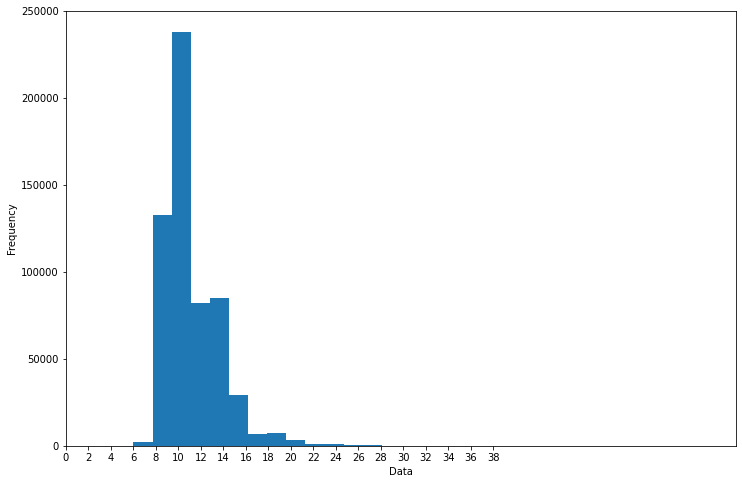

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.hist(distribution, bins=30)  # `density=False` would make counts
plt.xticks(range(0, 40, 2))
plt.ylabel('Frequency')
plt.xlabel('Data');

Из гистограммы видно, что если мы возьмем максимальную длину предложения 16, то охватим достаточно много примеров.

Создадим функцию, в которой настроим, как нам необходимо разбить датасет на батчи. В нашем случае мы возьмем максимальную длину 16, не забудем про спец. токены начала и конца предложения, итого максимальная длина будет 18.

Обратим внимание, что image_dim это вектор с извлеченными фичами из CNN модели! Вектор, который обычно далее направляется в полносвязный слой для классификации.

Чтобы сгенерировать батчи, мы создадим матрицы с нулевыми значениями, т.к. ноль у нас по умолчанию является индексом паддинга. Паддинг - это значение, которым "добиваем" вектор до нужной длины.

Пример добавления паддинга было >>> стало


[100, 83, 5621, 8753, 101] >>> [100, 83, 5621, 8753, 101, 0, 0, 0, ..., max_len]

In [ ]:
def collate_fn(dataset, max_len=16, image_dim=2048):
  # укажем максимальную длину, не забудем про спец. токены.
  max_len = max_len + 2 # bos & eos

  # инициализируем две матрицы состоящих из нулей, в которые будем добавлять вектора описаний и изображений
  # new_inputs нулевая матрица для изображений, размерность [кол-во примеров x размерность вектора изображения] 
  new_inputs = torch.zeros((len(dataset), image_dim), dtype=torch.float)
  # new_outputs нулевая матрица для описаний, размерность [кол-во примеров x макс. длина вектора, кот-ю мы определили]
  new_outputs = torch.zeros((len(dataset), max_len), dtype=torch.long)
  # пробежимся по всему датасету
  # sample: {'inputs': image, 'outputs': caption} как определили в class ExtDataset
  for i, sample in enumerate(dataset):
    # берем i-ю строку и добавляем в неё вектор изображения [0, 0, ..., 0] >>> [8.65001, 1.0012, ..., 0] 
    new_inputs[i, :] += np.array(sample['inputs'])
    # берем i-ю строку и добавляем в неё вектор описания [0, 0, ..., 0] >>> [100, 820, ..., 0] 
    new_outputs[i, :len(sample['outputs'])] += np.array(sample['outputs'])
  # заполненные матрицы возвращаем
  return {'input_ids': new_inputs, 'outputs': new_outputs}

Создадим наш энкодер, который будет брать вектор изображения и кодировать его в размерность скрытого состояния нашей RNN модели. Далее выход энкодера будем подавать на вход RNN системе в качестве скрытого состояния.

In [ ]:
class Encoder(nn.Module):
    # hid_dim: вектор скрытого состояния
    # n_layers: кол-во слоёв в RNN архитектуре, мы планируем использовать LSTM с 2-мя слоями
    # для этого нам нужно подготовить правильную размерность для скрытых состояний [n_layres, bs, hid_dim]
    # cnn_feature_dim: размерность извлеченного CNN моделью, вектора с фичами из изображения
    def __init__(self, hid_dim=512, n_layers=2, cnn_feature_dim=2048):
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers
        # инициализируем линейные слои
        self.cnn2h0 = nn.Linear(cnn_feature_dim, hid_dim)
        self.cnn2c0 = nn.Linear(cnn_feature_dim, hid_dim)
  
    def forward(self, image_vectors):       
        # input
        # image_vectors: [bs, cnn_feature_dim]
        # output
        # cnn2h0: [bs, hid_dim]
        # unsqueeze(0).repeat: [n_layers, bs, hid_dim]
        initial_hid = self.cnn2h0(image_vectors).unsqueeze(0).repeat(self.n_layers, 1, 1)
        initial_cell = self.cnn2c0(image_vectors).unsqueeze(0).repeat(self.n_layers, 1, 1)
        return initial_hid, initial_cell

Создадим модель, которая на вход будет принимать вектор с фичами извлеченными с помощью CNN из изображения, а выдавать логиты, распределение на слова в словаре.

In [ ]:
class CaptionNet(nn.Module):
    # emb_dim: размерность вектора слова
    # hid_dim: размерность скрытого состояния RNN
    # n_layers: кол-во слоёв в RNN
    # cnn_feature_dim: размерность извлеченного CNN моделью, вектора с фичами из изображения
    # vocab_size: размер словаря
    def __init__(self, emb_dim=256, hid_dim=512, n_layers=2, cnn_feature_dim=2048, dropout=0.3, vocab_size=30000):
        super(CaptionNet, self).__init__()

        self.vocab_size = vocab_size
        # создадим матрицу хранящую эмбеддинги (вектора) слов
        self.embedding = nn.Embedding(vocab_size, emb_dim)
            
        # инициализируем lstm модель
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers)
            
        # инициализируем линейный слой для получения логитов
        # hid_dim * 2: расширение с последующим сужением вектора признаков используется в BERT, даёт лучший результат 
        self.fc1 = nn.Linear(hid_dim, hid_dim * 2)
        self.fc2 = nn.Linear(hid_dim * 2 , vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, captions_ix, initial_hid, initial_cell):
        # [bs] >>> [1, bs]
        captions_ix = captions_ix.unsqueeze(0)
        # [1, bs, emb_dim]
        captions_emb = self.embedding(captions_ix)
        
        captions_emb = self.dropout(captions_emb)
        
        # outputs: [1, bs, hid_dim]
        # hidden and cell: [n_layers, bs, hid_dim]
        outputs, (hidden, cell) = self.lstm(captions_emb, (initial_hid, initial_cell)) # shape: [batch, caption_length, lstm_units]
        
        # logits: [bs, vocab_size]        
        logits = self.fc2(F.relu( self.fc1(outputs.squeeze()) ))
        
        return logits, hidden, cell

Соберем нашу модель из энкодера и декодера. Будем использовать тренировку методом Teacher forcing. В каждый момент времени t, когда модель сгенерировала токен, будем определять, на следующий шаг t+1 отдавать модели сгенерированный ею токен или правильный (как в описании).

In [ ]:
class ImgCap(nn.Module):
    def __init__(self, encoder, decoder, device, max_len):
        super(ImgCap, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_len = max_len
        self.vocab_size = self.decoder.vocab_size

    def forward(self, image_vectors, captions, teacher_forcing_ratio = 0.5):
        # input
        # image_vectors: [bs, image_vec]
        # captions: [len_seq, bs]

        # запишем размер батча и длину последовательности
        batch_size = image_vectors.shape[0]
        seq_len = captions.shape[0]

        # инициализируем тензор с нулевыми матрицами, куда будем записывать сгенерированные описания
        # [seq_len, bs, vocab_size]
        outputs = torch.zeros(seq_len, batch_size, self.vocab_size).to(self.device)
        # hidden and cell: [n_layers, bs, hid_dim]
        hidden, cell = self.encoder(image_vectors)
        # возьмем первые токены [CLS] из всех описаний в батче, чтобы отдать для генерации описания нашей RNN
        # input: [bs]
        input = captions[0]
        # будем генерировать токены исходя из длины последовательности (макс. длина, которую мы определили выше в def collate_fn)
        for t in range(1, seq_len):
            # output: [bs, vocab_size]
            # hidden and cell: [n_layers, bs, hid_dim]
            output, hidden, cell = self.decoder(input, hidden, cell)
            # outputs[t]: [bs, vocab_size]
            outputs[t] = output
            # random.random() - random number from 0 to 1
            teacher_force = random.random() < teacher_forcing_ratio
            # выберем самое вероятное слово из распределения для каждого описания в батче
            top1 = output.max(1)[1]
            # определяем, будем использовать сгененированные моделью токены или отдадим им правильные 
            input = (captions[t] if teacher_force else top1)
        return outputs

    def generate_one_example(self, imagepath, inception):
        
        test_image = face_recognition.load_image_file(imagePath)
  
        # Find all the faces in the test image using the default HOG-based model
        face_locations = face_recognition.face_locations(test_image)
      
        # Predict all the faces in the test image using the trained classifier
        names = []
        for i in range(len(face_locations)):
      
          test_image_enc = face_recognition.face_encodings(test_image)[i]
          names.append(clf.predict([test_image_enc]))
        

           
        # image: [299, 299, 3] -> [width, height, channel]
        # inception: модель CNN для извлечения фич из изображения

        # [width, height, channel] >> [channel, width, height]
        image = Image.open(imagePath)
        image = np.array(image.resize((299, 299))).astype('float32') / 255.
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        # извлечем фичи из изображения, нам понадобится вектор vectors_neck
        vectors_8x8, vectors_neck, logits = inception(image[None])

        outputs = []

        # поместим данные на gpu
        image_vectors = vectors_neck.to(self.device)

        #получим скрытое состояние из RNN
        hidden, cell = self.encoder(image_vectors)

        # в токенайзере возьмем id токена означающего начало описания 
        input = torch.tensor([tokenizer.token_to_id('[CLS]')]).to(device)

        # здесь вероятно нужно self.max_len, нужно уточнить
        for t in range(1, max_len):
            # output: [bs=1, vocab_size]
            output, hidden, cell = decoder(input, hidden, cell)
            # из распределения слов в словаре возьмем токен с самым высоким значением
            top1 = output.max(0)[1]
            outputs.append(top1)
            # добавим размерность, т.к. decoder принимает данные с размерностью [1, bs]
            input = (top1.unsqueeze(0))

        # у токенайзера возьмем id токена, означающего конец описания
        EOS_IDX = tokenizer.token_to_id('[SEP]')
        # возьмем последовательностей токенов и сгенерируем описание [100, 97893, 347, 735, 101] >>> [the dog is sleeping]
        k = 0
        for t in outputs:
            if t.item() != EOS_IDX:
              word = tokenizer.id_to_token(t.item())
              if word in ['person', 'man', 'woman']:
                print(names[k], end=' ')
                k+=1
              else:
                print(word, end=' ')
            else:
                break

In [ ]:
#@title Set parameters { vertical-output: true, display-mode: "form" }

lr = 1e-3 #@param
emb_dim = 128 #@param
hid_dim = 256 #@param
n_layers = 2 #@param
dropout = 0.3 #@param
batch_size = 300 #@param
num_epochs = 20 #@param

clip = 5
max_len = 18
vocab_size = 30000
cnn_feature_dim = 2048

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
PAD_IDX = tokenizer.token_to_id('[PAD]')

Инициализируем нашу модель и поместим на gpu

In [ ]:
encoder = Encoder(hid_dim, n_layers, cnn_feature_dim).to(device)
decoder = CaptionNet(emb_dim, hid_dim, n_layers, cnn_feature_dim, dropout, vocab_size).to(device)
model = ImgCap(encoder, decoder, device, max_len).to(device)

Инициализируем оптимайзер и лосс функцию. Важно! Лосс функции нужно указать id паддинга, чтобы он не учитывался при вычислении функции потерь.

In [ ]:
PAD_IDX = tokenizer.token_to_id('[PAD]')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Напишем функцию, которая вычисляет метрику BLUE, будем в ходе обучения наблюдать за данной метрикой.

In [ ]:
def get_blue(logits, captions):
    
    predict = torch.argmax(logits, -1)
    
    sentences = []
    targets = []

    for i in range(predict.shape[-1]):
        sentence_ids = predict[:, i].tolist()
        sentence = tokenizer.decode(sentence_ids)
        target_ids = captions[:, i].tolist()
        target = tokenizer.decode(target_ids)
        sentences.append([sentence])
        targets.append(target)
    
    return corpus_bleu(sentences, targets, smoothing_function=SmoothingFunction().method1)

Напишем тренировочный цикл.

In [ ]:
def train(model, dataloader, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0.
    blue = 0.
    
    for batch in dataloader:
        
        # [bs, image_vec]
        image_vectors = batch['input_ids'].to(device)        
        # [bs, len_seq] 
        captions = batch['outputs'].to(device)    
        # [len_seq, bs]
        captions = torch.transpose(captions, 1, 0)      

        optimizer.zero_grad()                      
        
        # [len_seq, bs, vocab_size]
        logits = model(image_vectors, captions)

        blue += get_blue(logits, captions)

        # сделаем необходимые решейпы для подачи данных в функцию потерь, не будем учитывать первые токены описаний
        # contiguous: вкратце, для корректных вычислений после изменений размерности  https://stackoverflow.com/questions/48915810/pytorch-contiguous
        # [(len_seq - 1) * bs, vocab_size]
        logits = logits[1:].contiguous().view(-1, logits.shape[-1]) 
        # [(len_seq - 1) * bs]
        captions = captions[1:].contiguous().view(-1)

        loss = criterion(logits, captions)
        
        loss.backward()
        
        # в RNN узкое место, это взрывающиеся градиенты, чтобы измежать числовой нестабильности, мы клипаем градиенты, если они большие
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    train_loss = round( (epoch_loss / len(dataloader)), 3)
    
    blue_mean = round((blue / len(dataloader)), 3) * 100
        
    return train_loss, blue_mean

In [ ]:
def evaluate(model, dataloader, criterion):
    
    model.eval()
    epoch_loss = 0
    blue = 0.
    
    with torch.no_grad():
    
        for batch in dataloader:

            image_vectors = batch['input_ids'].to(device)
            captions = batch['outputs'].to(device)
            captions = torch.transpose(captions, 1, 0)

            logits = model(image_vectors, captions)
            
            blue += get_blue(logits, captions)

            logits = logits[1:].contiguous().view(-1, logits.shape[-1])
            
            captions = captions[1:].contiguous().view(-1)

            loss = criterion(logits, captions)
            
            epoch_loss += loss.item()
            
        valid_loss = round((epoch_loss / len(dataloader)), 3)
        
        blue_mean = round((blue / len(dataloader)), 3) * 100
        
    return valid_loss, blue_mean

Подготовим наши данные.

In [ ]:
# разделим выборку на тестовую и валидационную
random.seed(42)
np.random.seed(42)
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [ ]:
train_dl = DataLoader(ExtDataset(train_img_codes, train_captions, tokenizer), batch_size=batch_size, collate_fn=collate_fn)
val_dl = DataLoader(ExtDataset(val_img_codes, val_captions, tokenizer), batch_size=batch_size, collate_fn=collate_fn)

Запустим тренировочный цикл.

In [ ]:
best_blue = 20.
for epoch in tqdm(range(num_epochs)):
  
    train_loss, train_blue_mean = train(model, train_dl, optimizer, criterion, clip)
    valid_loss, val_blue_mean = evaluate(model, val_dl, criterion)

    print('Epoch: {} \n Train Loss {}  Val loss {} \n Train Blue {} Val Blue {}:'.format(epoch + 1, train_loss, valid_loss, train_blue_mean, val_blue_mean))

    # сохраним модель с лучшей метрикой BLUE
    if best_blue < val_blue_mean:
        best_blue = val_blue_mean
        torch.save(model.state_dict(), 'imgcap.pth')

Epoch: 1 
 Train Loss 4.765  Val loss 4.238 
 Train Blue 9.8 Val Blue 16.900000000000002:
Epoch: 2 
 Train Loss 3.977  Val loss 3.794 
 Train Blue 22.1 Val Blue 26.5:
Epoch: 3 
 Train Loss 3.684  Val loss 3.615 
 Train Blue 28.7 Val Blue 29.9:
Epoch: 4 
 Train Loss 3.496  Val loss 3.551 
 Train Blue 31.8 Val Blue 33.0:
Epoch: 5 
 Train Loss 3.414  Val loss 3.525 
 Train Blue 33.300000000000004 Val Blue 32.300000000000004:
Epoch: 6 
 Train Loss 3.329  Val loss 3.459 
 Train Blue 34.300000000000004 Val Blue 34.699999999999996:
Epoch: 7 
 Train Loss 3.271  Val loss 3.459 
 Train Blue 35.0 Val Blue 34.4:
Epoch: 8 
 Train Loss 3.237  Val loss 3.374 
 Train Blue 35.5 Val Blue 35.4:
Epoch: 9 
 Train Loss 3.195  Val loss 3.406 
 Train Blue 36.1 Val Blue 35.4:
Epoch: 10 
 Train Loss 3.148  Val loss 3.339 
 Train Blue 36.5 Val Blue 36.6:
Epoch: 11 
 Train Loss 3.114  Val loss 3.457 
 Train Blue 36.9 Val Blue 36.1:


KeyboardInterrupt: ignored

Загрузим лучшую модель.

In [ ]:
model.load_state_dict(torch.load('imgcap.pth'))

<All keys matched successfully>

Скачаем обученную CNN модель inception и инициализируем её.

In [ ]:
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [ ]:
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Сгенерируем описание изображений.

In [ ]:
imagePaths = list(paths.list_images('test_captions'))
for (i, imagePath) in enumerate(imagePaths):
  

  model.generate_one_example(imagePath, inception)
  image = cv2.imread(imagePath)  
  cv2_imshow(image)
  cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.